In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import math
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from scipy import signal
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [3]:
'''
rates and angles come in as a list of arrays, with each array of angles being one the 7 anaotomical angles ['ankle', 'knee', 'hip', 'limbfoot', 'elbow', 'shoulder', 'forelimb']

1. peaks are identified and the angle is converted to phase
    phase is converted to a sine and cosine wave

the winer filter is trained to take reformatted neural data and turn it into a prediction of sine and cosine

2. predicted sine and cosine are used to find the angle of phase via arctan2
'''
def phase_train(rates, angles):
    full_rates, full_angles = session512.stitch_and_format(rates, angles)
    peak_list0 = tailored_peaks(full_angles, 0)
    peak_list1 = tailored_peaks(full_angles, 1)
    peak_list2 = tailored_peaks(full_angles, 2)
    peak_list3 = tailored_peaks(full_angles, 3)
    peak_list4 = tailored_peaks(full_angles, 4)
    peak_list5 = tailored_peaks(full_angles, 5)
    peak_list6 = tailored_peaks(full_angles, 6)
    phase_list0 = to_phasex(peak_list0, full_angles[:,0])
    phase_list1 = to_phasex(peak_list1, full_angles[:,1])
    phase_list2 = to_phasex(peak_list2, full_angles[:,2])
    phase_list3 = to_phasex(peak_list3, full_angles[:,3])
    phase_list4 = to_phasex(peak_list4, full_angles[:,4])
    phase_list5 = to_phasex(peak_list5, full_angles[:,5])
    phase_list6 = to_phasex(peak_list6, full_angles[:,6])
    phase_list = np.vstack((phase_list0,phase_list1,phase_list2,phase_list3,phase_list4,phase_list5,phase_list6)).T
    sin_array, cos_array = sine_and_cosine(phase_list)
    h, _, _, _ = decode_kfolds(X=full_rates, Y=full_angles)
    h_sin, _, _, _ = decode_kfolds(X=full_rates, Y=sin_array)
    h_cos, _, _, _ = decode_kfolds(X=full_rates, Y=cos_array)
    predicted_angle = predicted_lines(full_rates, h)
    predicted_sin = predicted_lines(full_rates, h_sin)
    predicted_cos = predicted_lines(full_rates, h_cos)
    radii = get_radii(predicted_sin, predicted_cos)
    arctans = arctan_fn(predicted_sin, predicted_cos)
    return arctans, radii, phase_list, predicted_sin, predicted_cos, sin_array, cos_array
 
def get_radii(sin, cos):
    radii = []
    for i in range(sin.shape[1]):
        sin_sq = np.square(sin[:,i])
        cos_sq = np.square(cos[:,i])
        rad_sq = sin_sq+cos_sq
        rad = np.sqrt(rad_sq)
        radii.append(rad)
    radii = np.array(radii).T
    return radii
    
# def arctan_fn_alt(predicted_sin, predicted_cos):   
#     arctans = []
#     for i in range(predicted_sin.shape[1]):
#         arctan_hold = []
#         for j in range(predicted_sin.shape[0]):
#             arctan = math.atan2(predicted_sin[j,i],predicted_cos[j,i])
#             angle = math.degrees(arctan)+180
#             arctan_hold = np.append(arctan_hold, angle)
#         arctans.append(arctan_hold)
#     arctans = np.array(arctans).T    
#     return arctans

# def arctan_fn(predicted_sin, predicted_cos):   
#     arctans = []
#     for i in range(predicted_sin.shape[1]):
#         arctan_angles = (np.arctan2(predicted_sin[:,i],predicted_cos[:,i]) * 180 / np.pi) +180
#         arctans.append(arctan_angles)
#     arctans = np.array(arctans).T
#     return arctans

def arctan_fn(predicted_sin, predicted_cos):   
    arctans = []
    for i in range(predicted_sin.shape[1]):
        arctan = np.arctan2(predicted_sin[:,i],predicted_cos[:,i])
        arctan_angles = np.degrees(arctan) + 180
        arctans.append(arctan_angles)
    arctans = np.array(arctans).T
    return arctans

# def sine_and_cosine(phase_list):
#     sin_array = []
#     cos_array = []
#     for i in range(phase_list.shape[1]):
#         sin = (np.sin(phase_list[:,i]*np.pi/180))
#         cos = (np.cos(phase_list[:,i]*np.pi/180))
#         sin_array.append(sin)
#         cos_array.append(cos)
#     sin_array = np.array(sin_array).T
#     cos_array = np.array(cos_array).T
#     return sin_array, cos_array

def sine_and_cosine(phase_list):
    phase_list = np.radians(phase_list - 180)
    sin_array = []
    cos_array = []
    for i in range(phase_list.shape[1]):
        sin = np.sin(phase_list[:,i])
        cos = np.cos(phase_list[:,i])
        sin_array.append(sin)
        cos_array.append(cos)
    sin_array = np.array(sin_array).T
    cos_array = np.array(cos_array).T
    return sin_array, cos_array
    
def predicted_lines(actual, H):
    holding_array = []
    for ii in range(H.shape[1]):
        temp1 = test_wiener_filter(actual, H[:,ii])
        holding_array.append(temp1)
    holding_array = np.array(holding_array).T
    return holding_array
    
def to_phasex(peaks, angles):
    for i in range(0,peaks.shape[0]-1):
        for j in range(0, peaks[i+1]-peaks[i]):
            angles[peaks[i]+j] = j*360/(peaks[i+1]-peaks[i])
        angles[-1] = 0
    return angles

                
def tailored_peaks(angles, index):
    peak_dict = {
            0 : {
                'signal': -(angles[:,index]),
                'prominence': 5,
                'distance': 5,
                'width' : 2,
                'height' : -1.2*np.mean(angles[:,index])
            },
            1 : {
                'signal': angles[:,index],
                'prominence': 10,
                'distance': None,
                'width' : None,
                'height' : np.mean(angles[:,index])
            },
            2 : {
                'signal': angles[:,index],
                'prominence': 5,
                'distance': None,
                'width' : 2,
                'height' : np.mean(angles[:,index])
            },
            3 : {
                'signal': angles[:,index],
                'prominence': 10,
                'distance': None,
                'width' : None,
                'height' : np.mean(angles[:,index])
            },
            4 : {
                'signal': angles[:,index],
                'prominence': 6.5,
                'distance': 5,
                'width' : None,
                'height' : 1.1*np.mean(angles[:,index])
            },
            5 : {
                'signal': -(angles[:,index]),
                'prominence': 5,
                'distance': None,
                'width' : None,
                'height' : -1.1*np.mean(angles[:,index])
            },
            6 : {
                'signal': angles[:,index],
                'prominence': 9,
                'distance': 5,
                'width' : None,
                'height' : None
            }
        }
    peaks, _ = spicy.signal.find_peaks(peak_dict[index]['signal'], prominence=peak_dict[index]['prominence'], distance =peak_dict[index]['distance'], width =peak_dict[index]['width'], height =peak_dict[index]['height'])    
    peaks = np.concatenate([[0],peaks,[np.shape(angles[:,index])[0]-1]])
    return peaks

def wave_align(waves):#, plot_req):
    temp_shift = []
    ts = np.linspace(0, (waves.shape[0]*50)/1000,waves.shape[0])
    dx = np.mean(np.diff(ts))
    for target in [waves[:,0], waves[:,1], waves[:,2]]:
        shift = (np.argmax(signal.correlate(waves[:,3], target)) - len(target)) * dx
        temp_shift = np.append(temp_shift, shift)
    temp_shift = np.append(temp_shift, 0)
    for target in [waves[:,4], waves[:,5]]:
        shift = (np.argmax(signal.correlate(waves[:,6], target)) - len(target)) * dx
        temp_shift = np.append(temp_shift, shift)
    temp_shift = np.append(temp_shift, 0)
    # temp_shift = np.array(temp_shift)
    return temp_shift

def alignment_check(tsf, arctans, full_phase):
    dx = np.mean(np.diff(tsf))
    temp_shift = []
    target = [arctans[:,0], arctans[:,1], arctans[:,2], arctans[:,3], arctans[:,4], arctans[:,5], arctans[:,6]]
    for i in range(len(target)):
        shift = (np.argmax(signal.correlate(full_phase[:,i], target[i])) - len(target[i])) * dx
        temp_shift.append(shift)
    return temp_shift

In [4]:
with open('/mnt/c/oobootoo/rat-fes/data/pickles/rat-annie_5-12_session.pkl', 'rb') as inp:
    session512 = pickle.load(inp)
rates512 = session512.data['rates']
angles512 = session512.data['angles']
coords512 = session512.data['coords']

In [5]:
arctans, radii, phase_list, predicted_sin, predicted_cos, sin_array, cos_array = phase_train(rates512, angles512)
tsf = np.linspace(0, (phase_list.shape[0]*50)/1000,phase_list.shape[0])

In [6]:
print(predicted_sin.shape)
print(radii.shape)

(14210, 7)
(14210, 7)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
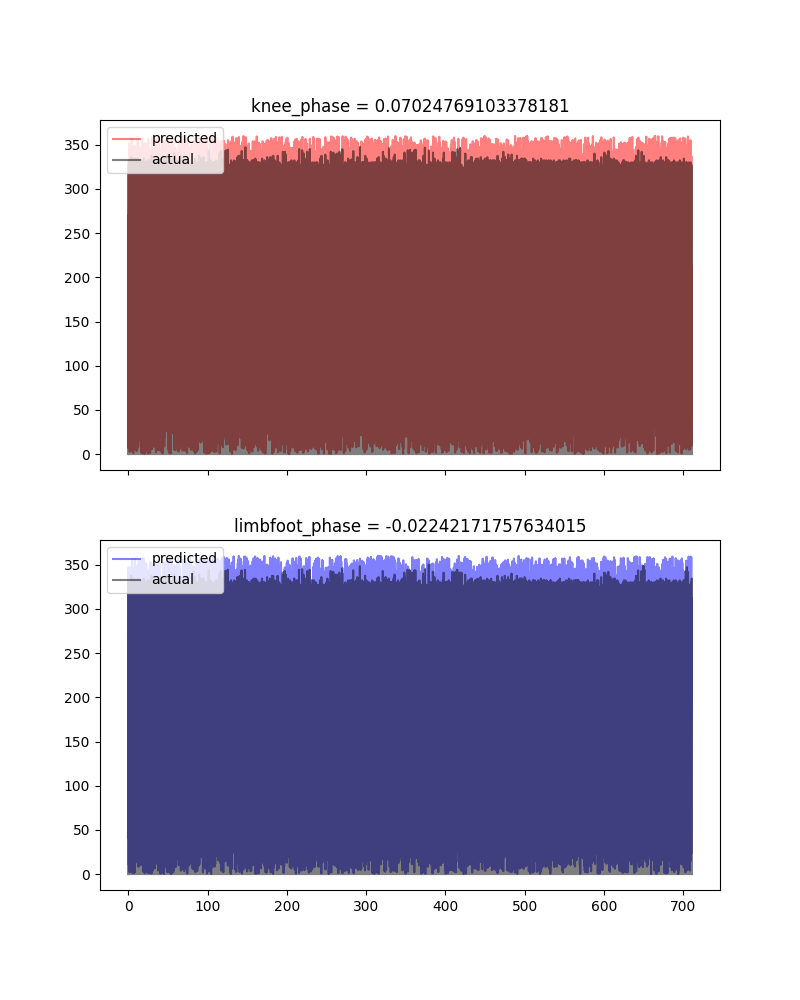

In [7]:
fig512, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].set_title('knee_phase = ' + str(vaf(phase_list[:,1],arctans[:,1])))
ax[0].plot(tsf, arctans[:,1], c='r', alpha=0.5, label = "predicted")
ax[0].plot(tsf, phase_list[:,1], c='k', alpha=0.5, label = "actual")

ax[0].legend(loc="upper left")
ax[1].set_title('limbfoot_phase = ' + str(vaf(phase_list[:,3],arctans[:,3])))
ax[1].plot(tsf, arctans[:,3], c='blue', alpha=0.5, label = "predicted")
ax[1].plot(tsf, phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax[1].legend(loc="upper left")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
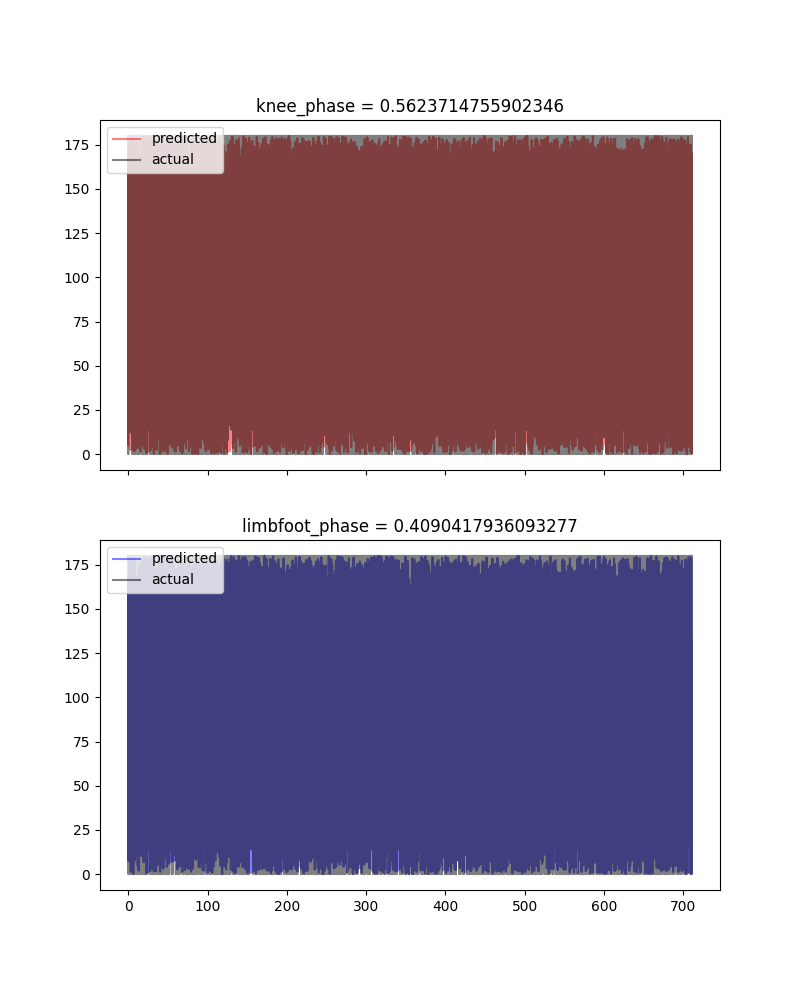

In [8]:
arctans1vaf = abs(arctans[:,1] - 180)
arctans3vaf = abs(arctans[:,3] - 180)
phaselist1vaf = abs(phase_list[:,1] - 180)
phaselist3vaf = abs(phase_list[:,3] - 180)


fig513, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].set_title('knee_phase = ' + str(vaf(phaselist1vaf,arctans1vaf)))
ax[0].plot(tsf, arctans1vaf, c='r', alpha=0.5, label = "predicted")
ax[0].plot(tsf, phaselist1vaf, c='k', alpha=0.5, label = "actual")

ax[0].legend(loc="upper left")
ax[1].set_title('limbfoot_phase = ' + str(vaf(phaselist3vaf,arctans3vaf)))
ax[1].plot(tsf, arctans3vaf, c='blue', alpha=0.5, label = "predicted")
ax[1].plot(tsf, phaselist3vaf, c='k', alpha=0.5, label = "actual")
ax[1].legend(loc="upper left")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
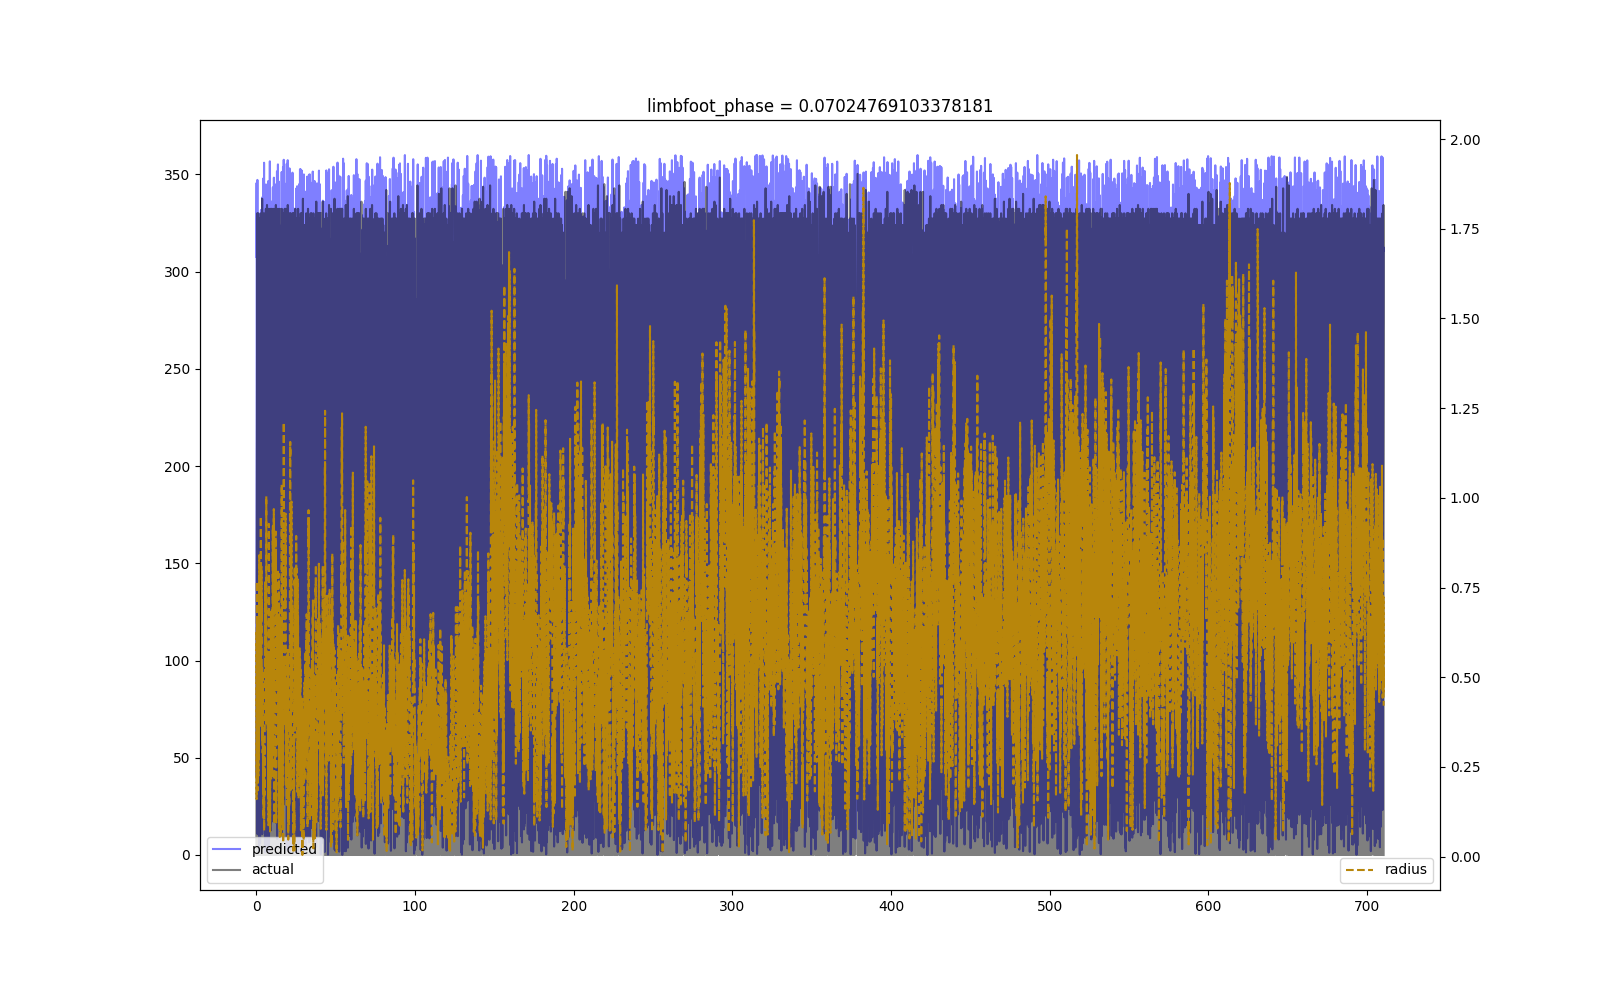

In [9]:
fig, ax1 = plt.subplots(figsize=(16,10))
ax2 = ax1.twinx()

ax1.set_title('limbfoot_phase = ' + str(vaf(phase_list[:,1],arctans[:,1])))
ax1.plot(tsf, arctans[:,3], c='b', alpha=0.5, label = "predicted")
ax1.plot(tsf, phase_list[:,3], c='k', alpha=0.5, label = "actual")
ax2.plot(tsf, radii[:,3], c='darkgoldenrod', label = "radius", linestyle='--')
ax1.legend(loc="lower left")
ax2.legend(loc="lower right")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
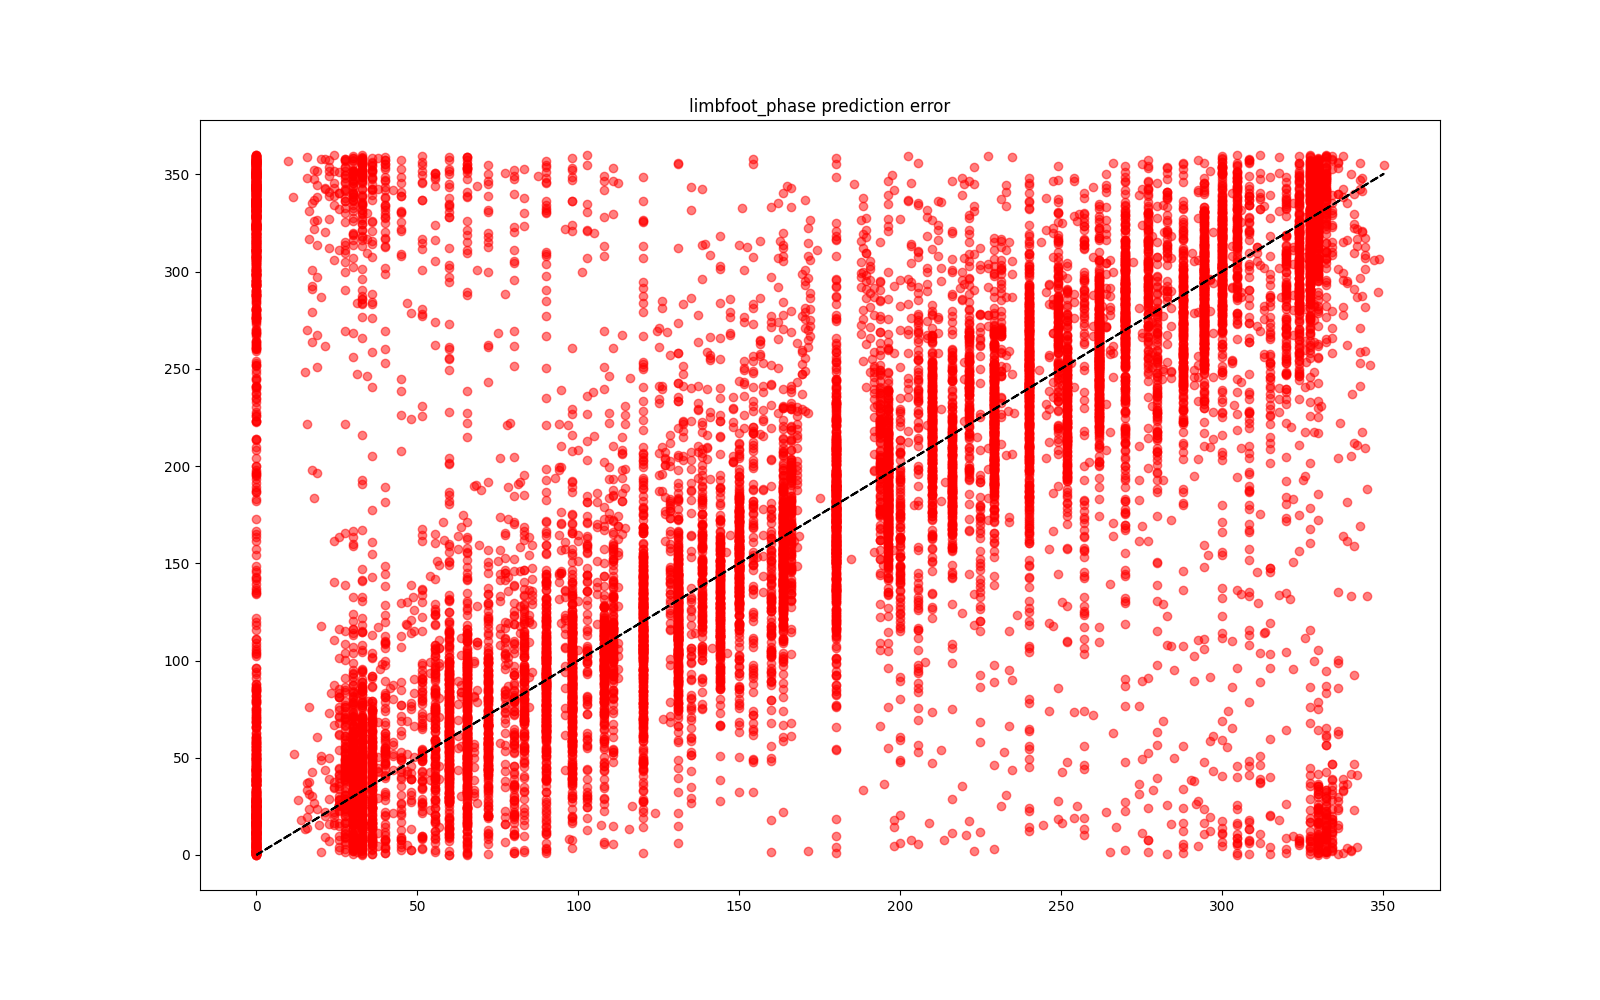

In [10]:
fig, ax1 = plt.subplots(figsize=(16,10))
ax1.set_title('limbfoot_phase prediction error')
ax1.scatter(phase_list[:,3], arctans[:,3], c='r', alpha=0.5, label = "predicted")
ax1.plot(phase_list[:,3], phase_list[:,3], c='k', linestyle='--')
# ax1.legend(loc="lower left")

<class 'numpy.ndarray'>


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
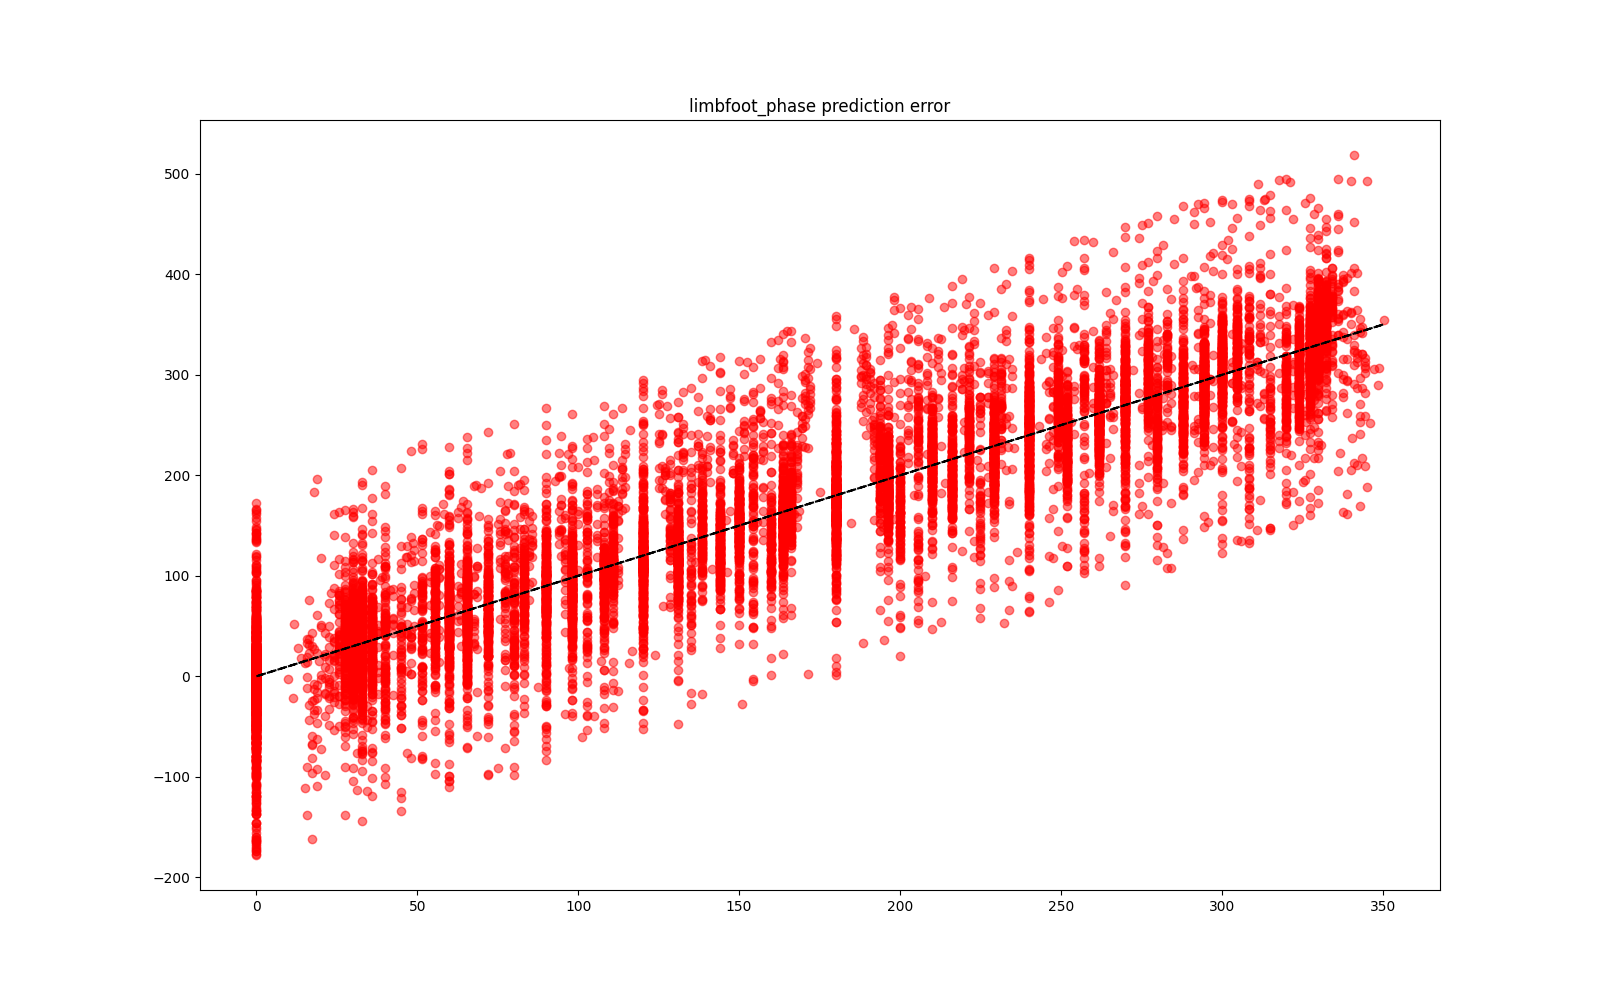

In [11]:
def anti_phase_alias(arctan,phase):
    print(type(phase))
    for i in range(phase.shape[0]):
        if (phase[i] < 180):
            if (arctan[i] > phase[i]+180):
                arctan[i] = arctan[i]-360
            else:
                continue
        else:
            if (arctan[i] < phase[i]-180):
                arctan[i] = arctan[i]+360
            else:
                continue
    return arctan
            
arctan3_aa = anti_phase_alias(arctans[:,3], phase_list[:,3])


fig, ax1 = plt.subplots(figsize=(16,10))
ax1.set_title('limbfoot_phase prediction error')
ax1.scatter(phase_list[:,3], arctan3_aa, c='r', alpha=0.5, label = "predicted")
ax1.plot(phase_list[:,3], phase_list[:,3], c='k', linestyle='--')
# ax1.legend(loc="lower left")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
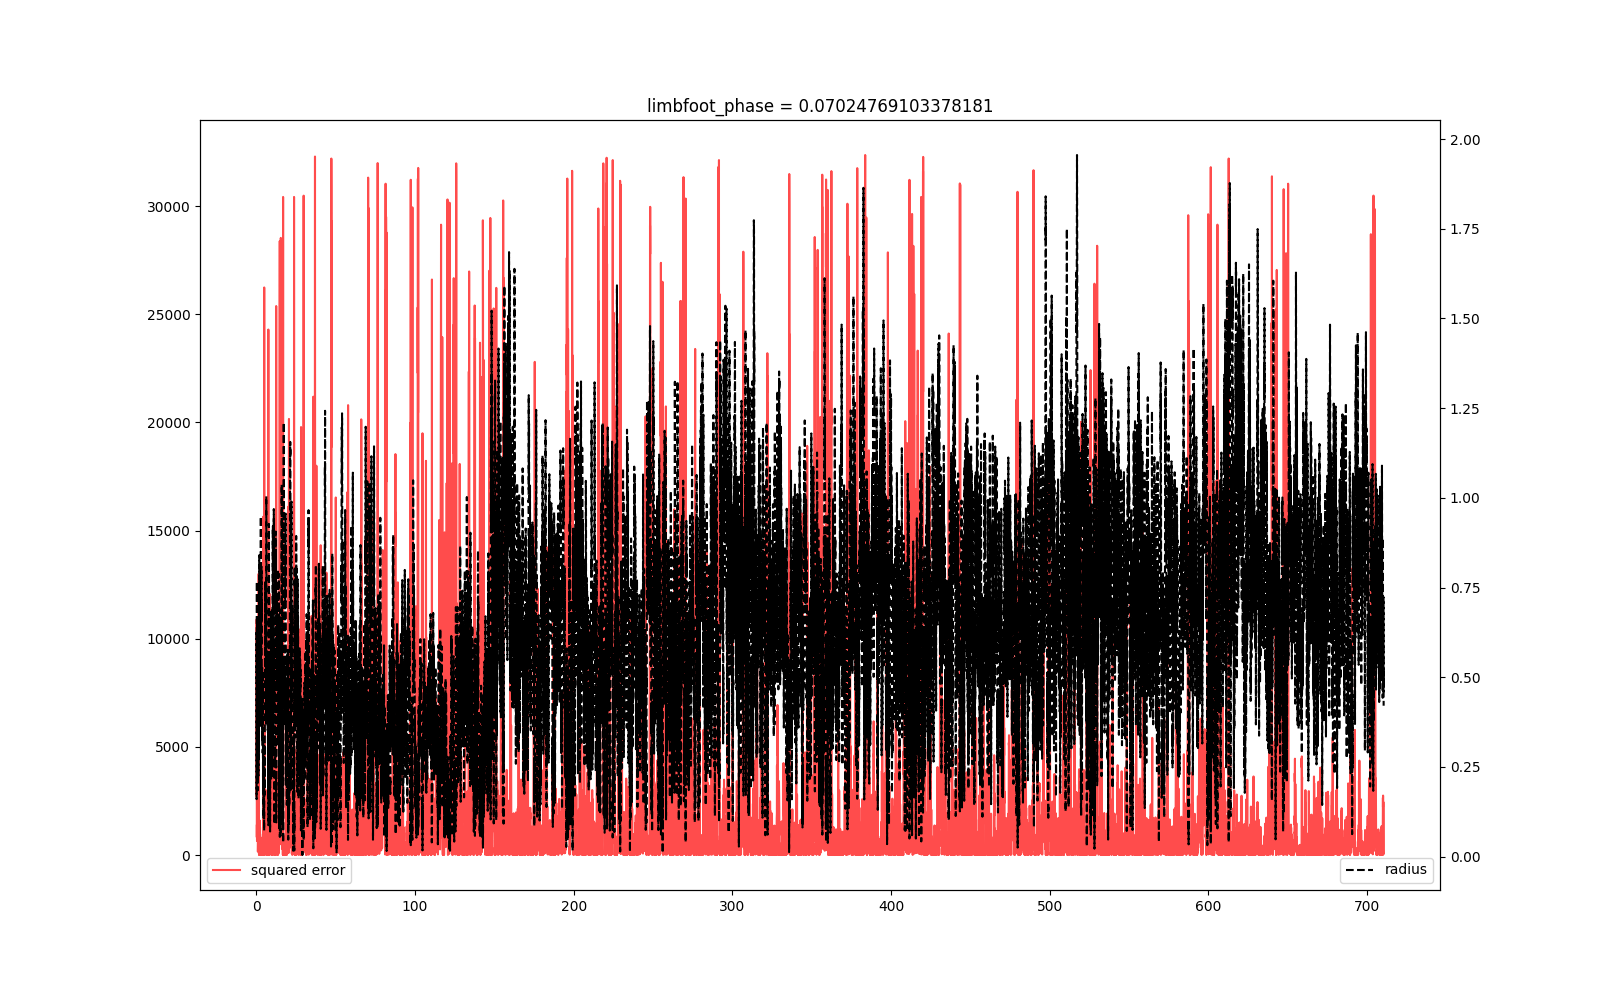

In [12]:
SE = np.square(arctans[:,3]-phase_list[:,3])
fig, ax1 = plt.subplots(figsize=(16,10))
ax2 = ax1.twinx()
ax1.set_title('limbfoot_phase = ' + str(vaf(phase_list[:,1],arctans[:,1])))
ax1.plot(tsf, SE, c='r', alpha=0.7, label = "squared error")
ax2.plot(tsf, radii[:,3], c='k', label = "radius", linestyle='--')
ax1.legend(loc="lower left")
ax2.legend(loc="lower right")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
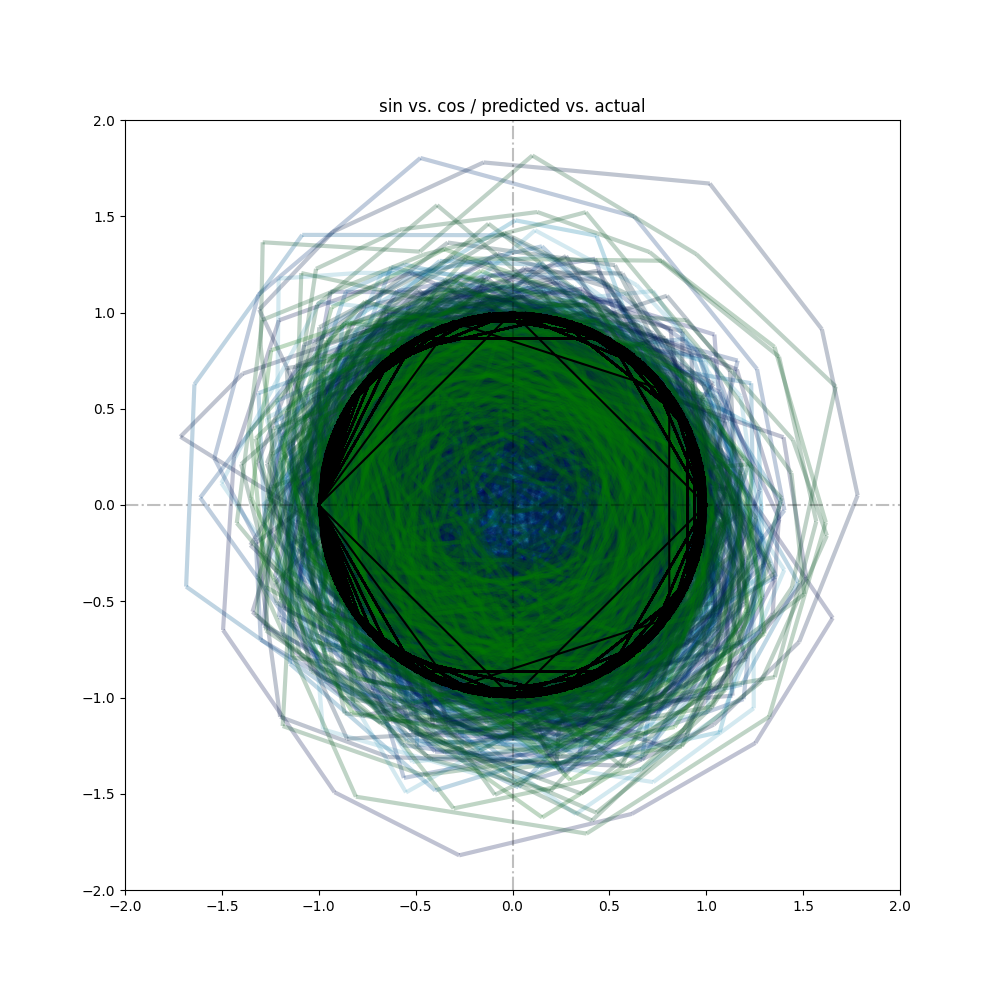

In [13]:
fig, axes = plt.subplots(figsize=(10,10))
y = predicted_sin[:,3]
x = predicted_cos[:,3]
lc = colorline(x, y, alpha=0.25, cmap='ocean_r') 
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.plot(cos_array[:,3], sin_array[:,3], c='k')
plt.axvline(x=0, c='k', alpha = 0.25, linestyle = '-.')
plt.axhline(y=0, c='k', alpha = 0.25, linestyle = '-.')
plt.title('sin vs. cos / predicted vs. actual') 
plt.show()

In [14]:
def polar_twin(ax):
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)
    # There should be a method for this, but there isn't... Pull request?
    ax2._r_label_position._t = (22.5 + 180, 0.0)
    ax2._r_label_position.invalidate()
    # Ensure that original axes tick labels are on top of plots in twinned axes
    for label in ax.get_yticklabels():
        ax.figure.texts.append(label)
    return ax2

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
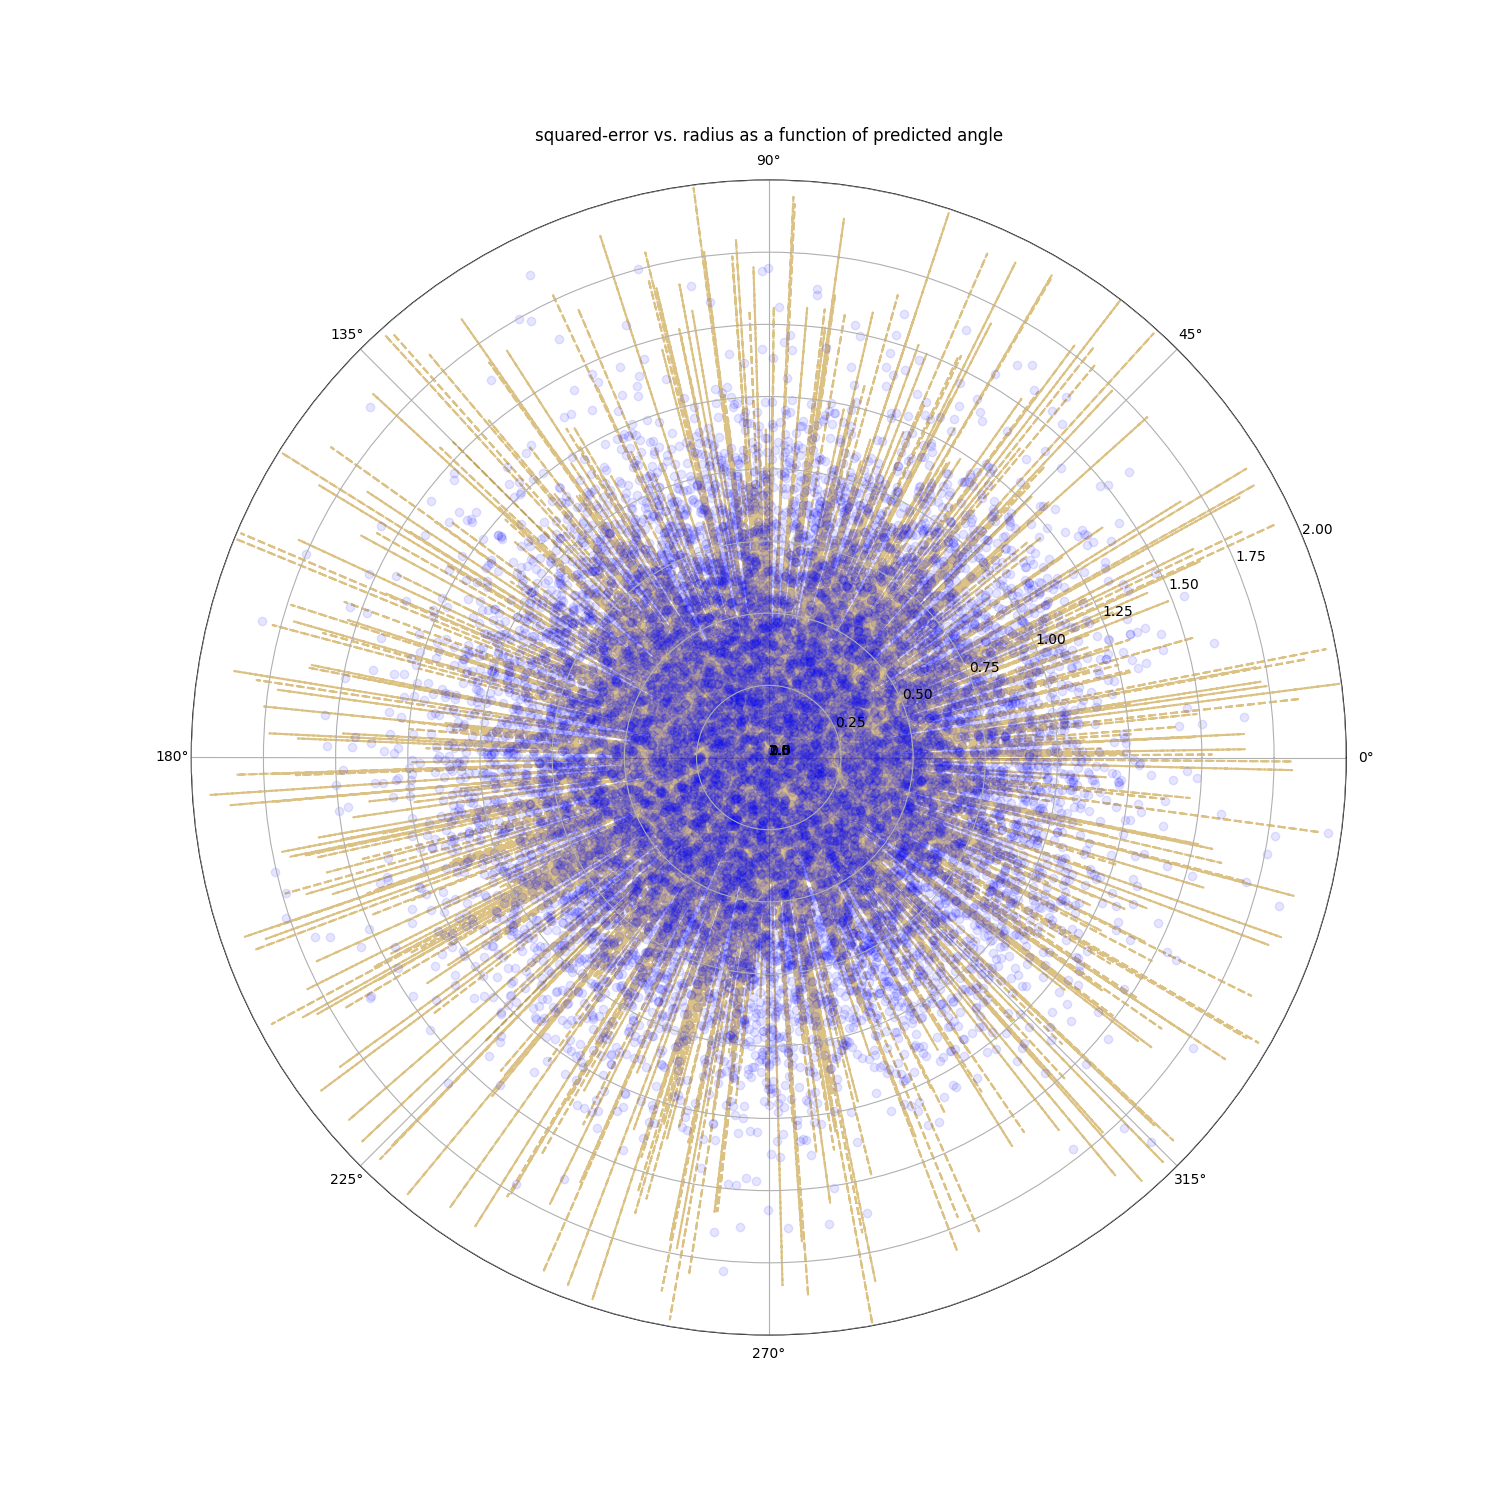

In [15]:
dupe = np.repeat(arctan3_aa, 2)
dupe_temp = np.repeat(SE, 2)
for i in range(dupe_temp.shape[0]):
    if (i % 2 == 1):
        dupe_temp[i] = 0
    else:
        continue
        
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(15,15))
ax.plot(dupe, dupe_temp, alpha = 0.5, linestyle = '--', c='darkgoldenrod')
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
# ax2 = ax.twintheta()
ax2 = polar_twin(ax)
ax.set_rlim([0, SE.max()])
ax2.scatter(arctans[:,3],radii[:,3], c='b', alpha = 0.1)
ax2.set_rlim([0, 2])
ax.set_title("squared-error vs. radius as a function of predicted angle", va='bottom')
plt.show()